In [1]:
import os
import pandas as pd

# Directory containing GProfiler outputs
gprofiler_dir = "D:/final project/project work/gprofiler"

# Collect functional terms from all CSVs
functional_terms = set()

for file in os.listdir(gprofiler_dir):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(gprofiler_dir, file))
        term_column = "name" if "name" in df.columns else "term_name"  # Adjust based on actual column
        terms = df[term_column].dropna().unique()
        functional_terms.update(map(str.strip, terms))

# Convert to list
functional_terms = list(functional_terms)

with open("functional_terms.txt", "w", encoding="utf-8") as f:
    for term in functional_terms:
        f.write(term + "\n")


In [2]:
# Assume previous block ran and we now have `functional_terms` list

# === STEP 2: Define diseases ===
diseases = [
    "Multiple Sclerosis",
    "Myasthenia Gravis",
    "Epilepsy",
    "Amyotrophic Lateral Sclerosis",
    "Encephalomyelitis Disseminata"
]


In [8]:
from Bio import Entrez
from tqdm import tqdm
import pandas as pd
import spacy
import time

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Set your email for Entrez
Entrez.email = "priyanshuprt@bicpu.edu.in"  # <- Replace with your actual email

# === STEP 1: Load functional terms from a .txt file ===
with open("functional_terms.txt", "r") as f:
    functional_terms = [line.strip() for line in f if line.strip()]

# === STEP 2: Specify diseases here ===
diseases = [
    "Multiple Sclerosis",
    "Myasthenia Gravis",
    "Epilepsy",
    "Amyotrophic Lateral Sclerosis",
    "Encephalomyelitis Disseminata"
]

# Max abstracts to fetch per query
MAX_ABSTRACTS = 20

def search_pubmed(term, disease, max_results=MAX_ABSTRACTS):
    query = f'"{term}" AND "{disease}"'
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    record = Entrez.read(handle)
    handle.close()
    return record["IdList"]

def fetch_abstracts(pmid_list):
    if not pmid_list:
        return []
    handle = Entrez.efetch(db="pubmed", id=pmid_list, rettype="abstract", retmode="text")
    abstracts = handle.read().split("\n\n")
    handle.close()
    return abstracts

def extract_contexts(term, abstract, window=30):
    contexts = []
    doc = nlp(abstract)
    for sent in doc.sents:
        if term.lower() in sent.text.lower():
            contexts.append(sent.text.strip())
    return contexts

# === STEP 3: Run mining and collect results ===
results = []

for term in tqdm(functional_terms, desc="Functional Terms"):
    for disease in diseases:
        try:
            pmids = search_pubmed(term, disease)
            time.sleep(1)
            abstracts = fetch_abstracts(pmids)
            for abstract in abstracts:
                contexts = extract_contexts(term, abstract)
                for ctx in contexts:
                    results.append({
                        "Functional Term": term,
                        "Disease": disease,
                        "Context": ctx
                    })
        except Exception as e:
            print(f"Error with term '{term}' and disease '{disease}': {e}")

# === STEP 4: Save output ===
df = pd.DataFrame(results)
df.to_csv("functional_term_literature_contexts.csv", index=False)
print("Results saved to 'functional_term_literature_contexts.csv'")

Functional Terms: 100%|██████████████████████████████████████████████████████████████| 153/153 [37:04<00:00, 14.54s/it]

Results saved to 'functional_term_literature_contexts.csv'


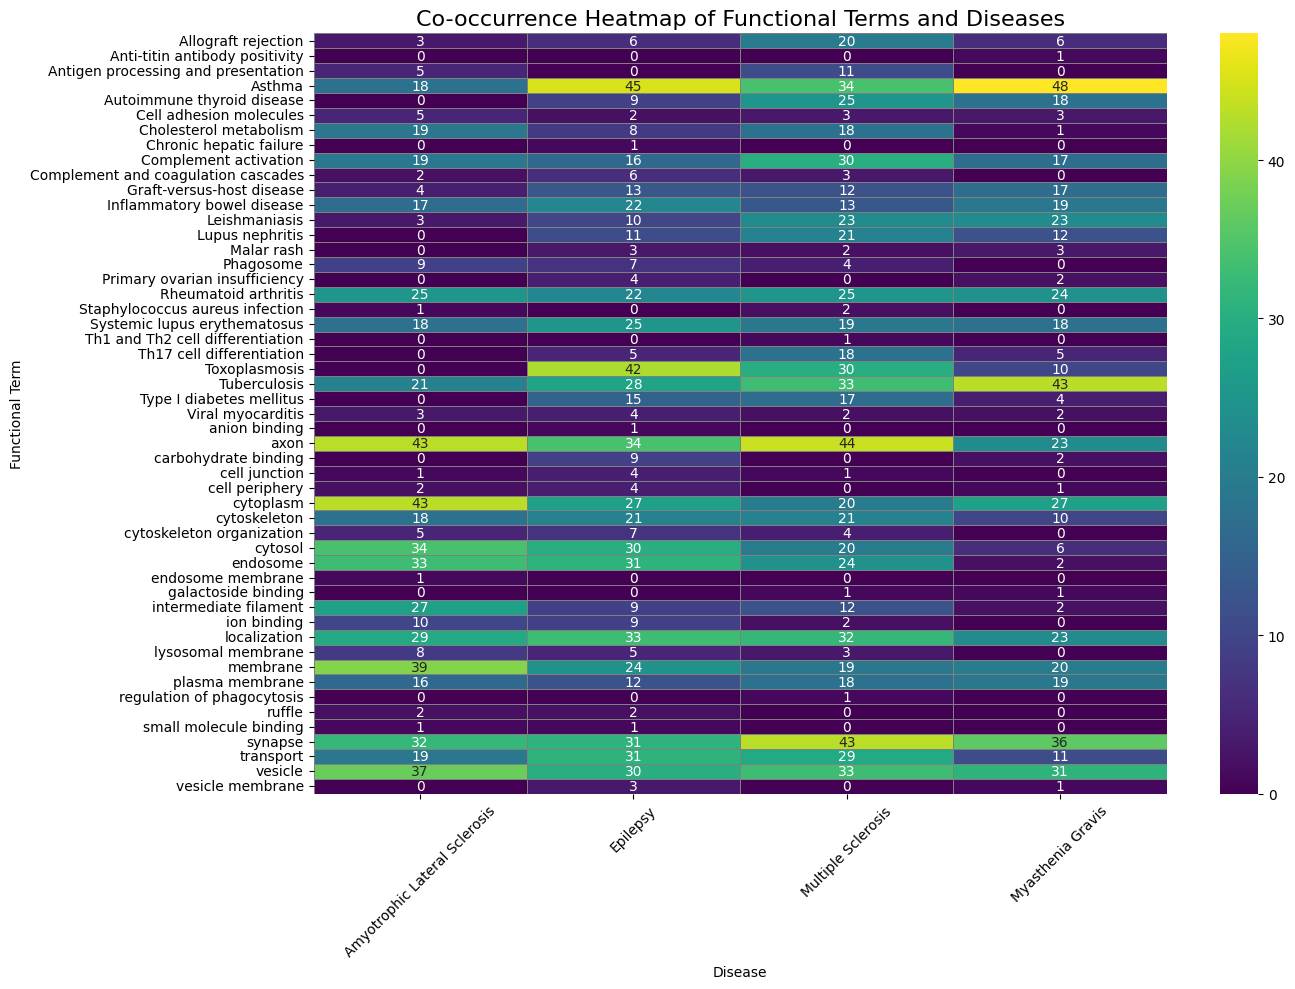

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from wordcloud import WordCloud
import os

# === Step 1: Load the CSV file ===
df = pd.read_csv("functional_term_literature_contexts.csv")

# === Step 2: Basic Cleanup ===
df.dropna(subset=["Functional Term", "Disease", "Context"], inplace=True)

# === Step 3: Count co-occurrences ===
co_occurrence = df.groupby(["Functional Term", "Disease"]).size().reset_index(name="Count")

# === Step 4: Pivot for heatmap ===
heatmap_data = co_occurrence.pivot(index="Functional Term", columns="Disease", values="Count").fillna(0)

# === Step 5: Plot Heatmap ===
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap="viridis", linewidths=0.5, linecolor="gray", annot=True, fmt=".0f")
plt.title("Co-occurrence Heatmap of Functional Terms and Diseases", fontsize=16)
plt.ylabel("Functional Term")
plt.xlabel("Disease")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("functional_term_disease_heatmap.png", dpi=300) 
plt.show()




In [9]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\priya\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip
